<a href="https://colab.research.google.com/github/TTD-JPO/TDD-project/blob/main/Main_TweetDisasterDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Twitter Disaster Detection

<center>

# Load Libs & Data

In [1]:
import pandas as pd
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta, time

In [2]:
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

In [3]:
from sklearn.pipeline import make_pipeline


from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score, plot_confusion_matrix, roc_auc_score, roc_curve

from sklearn.naive_bayes import CategoricalNB, MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [4]:
import re
import string
import nltk

nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import STOPWORDS
from nltk.stem import PorterStemmer

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[Link to data (csv) @google drive](https://drive.google.com/file/d/1QPragNh_wYQVsXQvds8sqjDMfzARD638/view?usp=sharing)


In [5]:
url = 'https://raw.githubusercontent.com/TTD-JPO/TDD-project/main/disaster_tweets.csv'
disaster_tweets = pd.read_csv(url, encoding='latin-1')

# Helper function

In [6]:
pipe_name=[]
auc=[]
fpr=[]
tpr=[]

In [7]:
def clean_text(text):
  # get rid of all unwanted punctuation and digits
  text = text.replace("´", "'")

  digi_punct = "[^a-zA-Z' ]"
  text = re.sub(digi_punct, " ", text)
  text = " ".join(text.split())
  text = text.lower()

  return text

def my_df_text_mining(df, col): # lemmatizer
  lemmatizer = WordNetLemmatizer()
  my_stopwords = stopwords.words("english")
  
  df["_no_stopwords"] = df[col].apply(             lambda texxt: " ".join([word for word in clean_text(texxt).split() if word not in my_stopwords]))
  df[col]             = df["_no_stopwords"].apply( lambda texxt: " ".join([lemmatizer.lemmatize(word) for word in texxt.split()]) )

  return df.drop(["_no_stopwords"], axis=1)


def my_df_text_mining2(df, col): #stemming
  stemmer = PorterStemmer()
  my_stopwords = stopwords.words("english")
  
  df["_no_stopwords"] = df[col].apply(             lambda texxt: " ".join([word for word in clean_text(texxt).split() if word not in my_stopwords]))
  df[col]             = df["_no_stopwords"].apply( lambda texxt: " ".join([stemmer.stem(word) for word in texxt.split()]) )

  return df.drop(["_no_stopwords"], axis=1)
 ############################################# 

def my_df_spacy_locgpe(df, col):  
  df["loc_gpe"] = df[col].apply( lambda texxt: " ".join([ ent.text for ent in nlp( clean_text(texxt) ).ents  if ((ent.label_ =='LOC') | (ent.label_ =='GPE'))]) )
  return df

def my_df_spacy_date_time(df, col):
  df["date_time"] = df[col].apply( lambda texxt: " ".join([ ent.text for ent in nlp( clean_text(texxt) ).ents  if ((ent.label_ =='DATE') | (ent.label_ =='TIME'))]) )
  return df

def my_df_spacy_fac(df, col):
  df["FAC"] = df[col].apply( lambda texxt: " ".join([ ent.text for ent in nlp( clean_text(texxt) ).ents  if (ent.label_ =='FAC') ]) )
  return df
################################

def spcy_test(text):
  displacy.render(nlp(clean_text(text)), style='ent', jupyter=True)

################################

def corpus_func(series):
    '''create a text block (corpus) from a series'''
    return " #### ".join(text for text in series)

def corpus_list(corpus):
    '''create a list from text block (corpus)'''
    corpus_list = lambda x: x.split(' #### ')

In [8]:
#jedi's helpers
#
def plot_roc_auc(pipe_name_list, fpr_list, tpr_list, auc_list):
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title(f"ROC curve with test-AUC")

  for pn, fpr, tpr, auc in zip(pipe_name_list, fpr_list, tpr_list, auc_list):
    plt.plot(fpr, tpr, label=pn+" auc:"+str(f"{auc:0.3f}"))
  
  plt.legend(fontsize=10) # using a size in points
  plt.legend(loc='best')
  plt.show()
#end


def my_fit_cm(df, pipe, feature_list, target):
  # includes train test split, model fit, and
  # plots confusion matrix
  #

  X_train, X_test,\
  y_train, y_test =\
  train_test_split(df[feature_list],
                    df[target],
                    test_size=0.2,
                    random_state=314159,
                    stratify=df[target])

  #display( cross_val_score(pipe, X_train, y_train).mean() )

  pipe.fit(X_train, y_train)
  plot_confusion_matrix(pipe, X_train, y_train, values_format="0.3f", normalize='true', cmap=plt.cm.Blues)#, cmap="RdYlGn")
  plt.title(f"best accuracy: { accuracy_score(y_train, pipe.predict(X_train)):0.3f}")
  
  plot_confusion_matrix(pipe, X_test, y_test, values_format="0.3f", normalize='true', cmap=plt.cm.Blues)#, cmap="RdYlGn")
  plt.title(f"best accuracy: { accuracy_score(y_test, pipe.predict(X_test)):0.3f}")
  plt.show()

# ROC curve with AUC ##
  plt.plot([0, 1], [0, 1], 'k--')
  fpr, tpr, thresholds = roc_curve(y_train, pipe.predict_proba(X_train)[:, 1] )
  plt.plot(fpr, tpr, label='train', c="black")

  fpr_, tpr_, thresholds_ = roc_curve(y_test, pipe.predict_proba(X_test)[:, 1] )
  plt.plot(fpr_, tpr_, label='test', c="red")
#### show real values in plot as text
  offset_x,offset_y = -0.25 , 0.025
  fpr__, tpr__, thresholds_ = roc_curve(y_test, pipe.predict(X_test) )
  if (fpr__[1] < -offset_x) :   offset_x, offset_y = offset_y, -offset_y
  plt.text(fpr__[1]+offset_x, tpr__[1]+offset_y, f"({fpr__[1]:0.3f}, {tpr__[1]:0.3f})", c="r")
  plt.scatter(fpr__[1], tpr__[1], c="red")
####
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  test_auc_score = roc_auc_score(y_test, pipe.predict(X_test))
  plt.title(f"ROC curve with test-AUC:{test_auc_score:0.3f}")
  plt.legend(loc='best')
  plt.show()

  return fpr_, tpr_ , test_auc_score   # for further plotting ...
  # end


In [9]:
def plot_words_to_target (df, wordlist, target):
    '''group word lists according to target values and form mean value
       plot wordlist ans target, sorted by wordlist '''
    df['target_mean'] = df.groupby(wordlist)[target].transform('mean')

    fig = plt.figure(figsize=(8, 72), dpi=100)

    sns.countplot(y=df.sort_values(by='target_mean', ascending=False)[wordlist],
                hue=df.sort_values(by='target_mean', ascending=False)[target])

    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=12)
    plt.legend(loc=1)
    plt.title(f'Target Distribution in {wordlist}')

In [10]:
#OCF


## Evaluate data

In [11]:
disaster_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [12]:
print( "absolute number of disaster indicated messages:", disaster_tweets.target.sum() )
print( f"relative number of disaster indicated messages: {disaster_tweets.target.sum() / disaster_tweets.shape[0] :0.3f}" )

absolute number of disaster indicated messages: 3271
relative number of disaster indicated messages: 0.430


In [13]:
keys      = list(disaster_tweets.keyword.unique() )
locations = list(disaster_tweets.location.unique() )
print(f'len_keys: {len(keys)}\tlen_locations: {len(locations)}')

len_keys: 222	len_locations: 3342


In [14]:
disaster_tweets.groupby('keyword').target.count().sort_values(ascending=False)

keyword
fatalities               45
deluge                   42
armageddon               42
body%20bags              41
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: target, Length: 221, dtype: int64

In [15]:
disaster_tweets.groupby('location').target.count().sort_values(ascending=False)

location
USA                            104
New York                        71
United States                   50
London                          45
Canada                          29
                              ... 
Republica Dominicana             1
Republic of the Philippines      1
Regalo Island                    1
Redondo Beach, CA                1
                                 1
Name: target, Length: 3341, dtype: int64

In [16]:
display( f"relative number of keyword   messages: {disaster_tweets.keyword.nunique()  / disaster_tweets.shape[0] :0.3f}" )
display( f"relative number of location  messages: {disaster_tweets.location.nunique() / disaster_tweets.shape[0] :0.3f}" )

'relative number of keyword   messages: 0.029'

'relative number of location  messages: 0.439'

## Visualization of data (of)

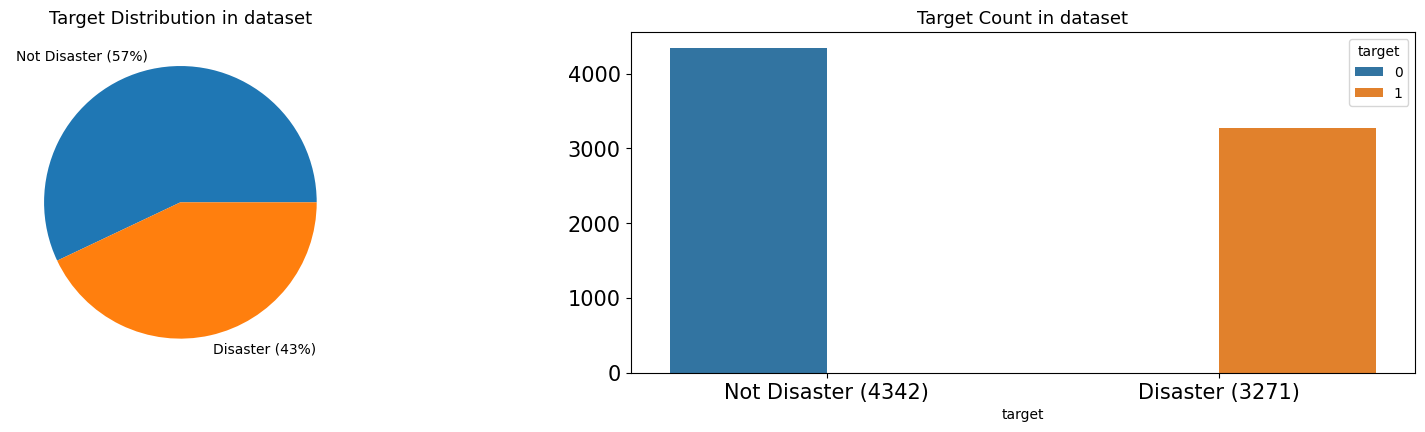

In [17]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

disaster_tweets.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
sns.countplot(x=disaster_tweets['target'], hue=disaster_tweets['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in dataset', fontsize=13)
axes[1].set_title('Target Count in dataset', fontsize=13)

plt.show()

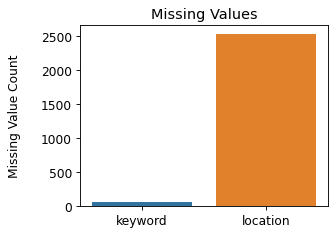

In [18]:
missing_cols = ['keyword', 'location']

plt.figure(figsize=(4, 3), dpi=80)

sns.barplot(x=disaster_tweets[missing_cols].isna().sum().index, y=disaster_tweets[missing_cols].isna().sum().values)

plt.ylabel('Missing Value Count', size=11, labelpad=18)
plt.tick_params(axis='x', labelsize=11)
plt.tick_params(axis='y', labelsize=11)

plt.title('Missing Values', fontsize=13)

plt.show()

# Cleaning of data 
- df deaster tweets - 'dtt_clean'

In [19]:
dtt_clean = disaster_tweets.copy()

### clean NaN

In [20]:
missing_cols = ['keyword', 'location']
for col in  missing_cols:
    dtt_clean[col] = dtt_clean[col].fillna(f'no_{col}')

In [21]:
dtt_clean.head(2)

,id,keyword,location,text,target
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1


# Analizing tweet < text >
- NLP text 
- NLP keyword, localization 

In [22]:
dtt_clean = my_df_text_mining(dtt_clean, 'text')

In [23]:
dtt_clean.head(3)

,id,keyword,location,text,target
0,1,no_keyword,no_location,deed reason earthquake may allah forgive u,1
1,4,no_keyword,no_location,forest fire near la ronge sask canada,1
2,5,no_keyword,no_location,resident asked 'shelter place' notified office...,1


In [24]:
#Regex:
dtt_clean['keyword_re'] = dtt_clean.keyword.apply(lambda text: re.sub("%20"," ", text))  # leerzeichen !!!

In [25]:
keyword_low=[x.lower() for x in dtt_clean['keyword_re']]

In [26]:
# analog to goupby in Evaluate data (but after clean keyword)
# make a count for the keyword list

key_count = sorted(Counter(list(dtt_clean['keyword_re'])).items(), key = lambda kv:( kv[1], kv[0]), reverse=True)
print(key_count[0:20])

[('no_keyword', 61), ('fatalities', 45), ('deluge', 42), ('armageddon', 42), ('sinking', 41), ('harm', 41), ('damage', 41), ('body bags', 41), ('windstorm', 40), ('twister', 40), ('siren', 40), ('outbreak', 40), ('fear', 40), ('evacuate', 40), ('collided', 40), ('wrecked', 39), ('wreckage', 39), ('whirlwind', 39), ('weapons', 39), ('weapon', 39)]


In [27]:
stemmer = PorterStemmer()

newColumn = []
for w in keyword_low: 
    newColumn.append(stemmer.stem(w))

dtt_clean['keyword_clean'] = newColumn

In [28]:
key_stem_count = sorted(Counter(list(dtt_clean['keyword_clean'])).items(), key = lambda kv:( kv[1], kv[0]), reverse=True)
print(key_stem_count[0:20])

[('fatal', 120), ('evacu', 112), ('derail', 112), ('flood', 109), ('body bag', 107), ('scream', 105), ('drown', 104), ('bomb', 101), ('hijack', 100), ('suicide bomb', 99), ('obliter', 91), ('weapon', 78), ('wreck', 76), ('death', 74), ('collid', 74), ('blaze', 72), ('quarantin', 71), ('injuri', 71), ('explod', 71), ('attack', 71)]


In [29]:
print(f"key_unique, org:     {len(keys)}\t locations: {len(locations)}")
print(f"key_unique, regex:   {len(dtt_clean['keyword_re'].unique())}")
print(f"key_unique, stemmed: {len(dtt_clean['keyword_clean'].unique())}")

key_unique, org:     222	 locations: 3342
key_unique, regex:   222
key_unique, stemmed: 167


In [30]:
dtt_clean.head(3)

,id,keyword,location,text,target,keyword_re,keyword_clean
0,1,no_keyword,no_location,deed reason earthquake may allah forgive u,1,no_keyword,no_keyword
1,4,no_keyword,no_location,forest fire near la ronge sask canada,1,no_keyword,no_keyword
2,5,no_keyword,no_location,resident asked 'shelter place' notified office...,1,no_keyword,no_keyword


In [31]:
no_target_ = dtt_clean[ dtt_clean.target == 0]
target_    = dtt_clean[ dtt_clean.target == 1]

## Keywords

In [32]:
df_keys = dtt_clean.copy()

Distribution of the key words to disaster (= 1) and false message (= 0)

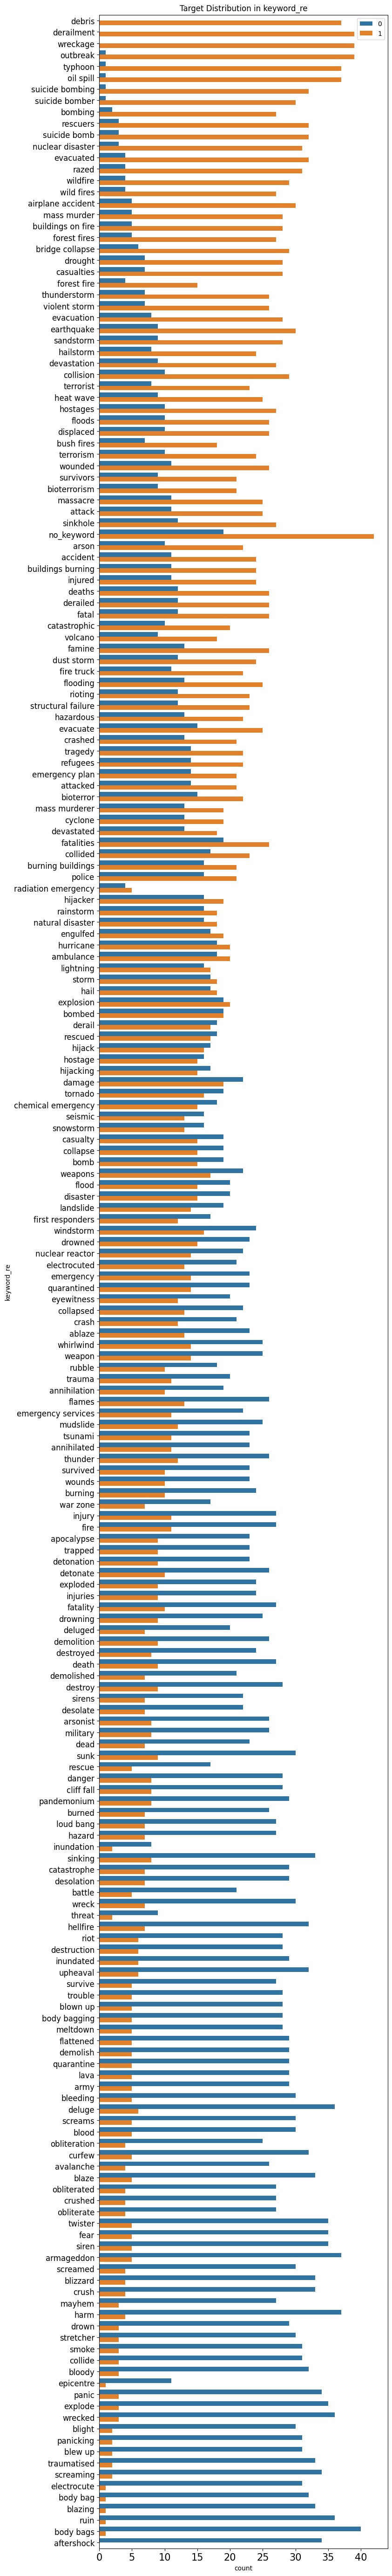

In [33]:
# keywords with regex
plot_words_to_target (df_keys, 'keyword_re', 'target')

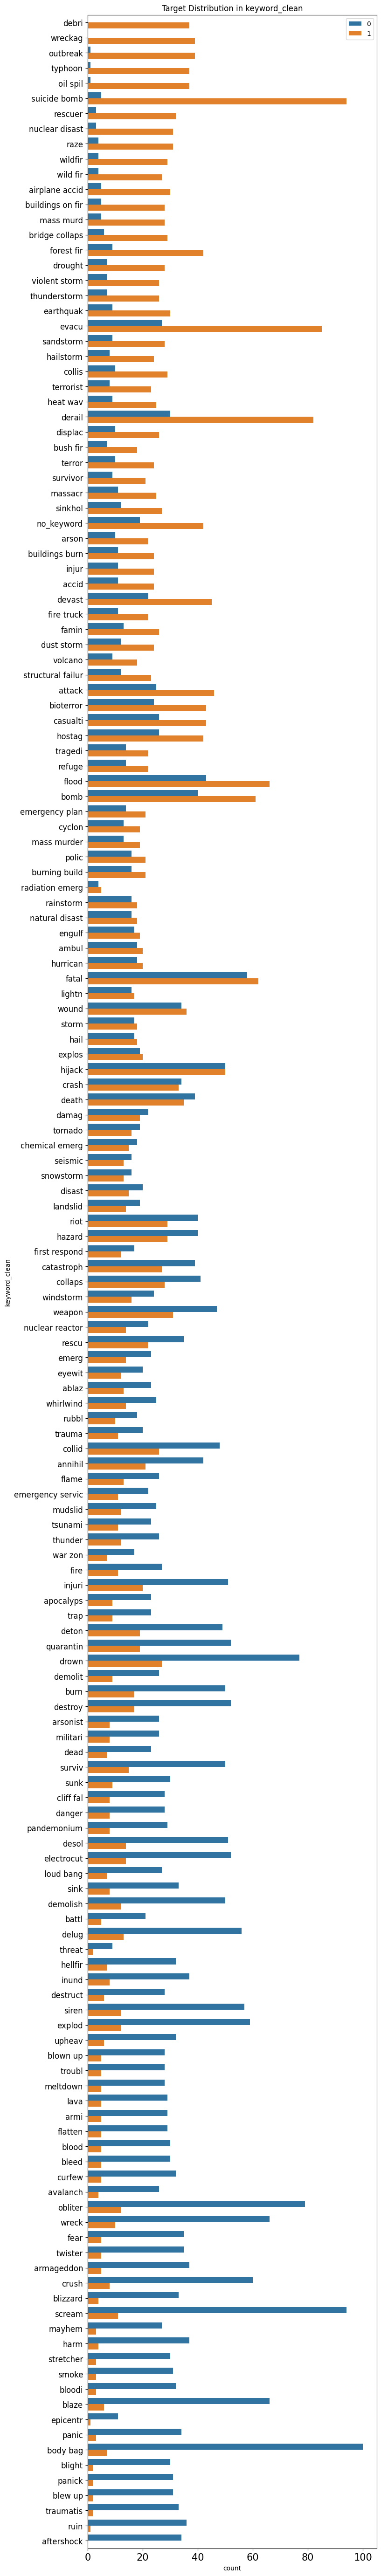

In [34]:
# keywords with regex and porterstemmer
plot_words_to_target (df_keys, 'keyword_clean', 'target')

## Location

In [35]:
location_count = sorted(Counter(list(dtt_clean['location'])).items(), key = lambda kv:( kv[1], kv[0]), reverse=True)
location_count[0:20]

[('no_location', 2533),
 ('USA', 104),
 ('New York', 71),
 ('United States', 50),
 ('London', 45),
 ('Canada', 29),
 ('Nigeria', 28),
 ('UK', 27),
 ('Los Angeles, CA', 26),
 ('India', 24),
 ('Mumbai', 22),
 ('Washington, DC', 21),
 ('Kenya', 20),
 ('Worldwide', 19),
 ('Chicago, IL', 18),
 ('Australia', 18),
 ('California', 17),
 ('New York, NY', 15),
 ('Everywhere', 15),
 ('California, USA', 15)]

In [36]:
#df only no_location (NAN)
df_location = disaster_tweets.copy()
df_location.dropna(subset=['location'], inplace= True)
location_uni= df_location.location.unique()

In [37]:
location_text = corpus_func(df_location['location'])
location_text[:100]

'Birmingham #### Est. September 2012 - Bristol #### AFRICA #### Philadelphia, PA #### London, UK ####'

In [38]:
%time spcy_test(location_text[:200])

CPU times: user 21.1 ms, sys: 9 µs, total: 21.1 ms
Wall time: 25.3 ms


In [39]:
# Convert the machine learning text document into a spacy document.
# This automatically does POS tagging for you!

nlp = spacy.load('en_core_web_sm')
doc = nlp(location_text)
print(f' doc_type: {type(doc)}\n doc_len: {len(doc)}')

# Count the frequencies of a given attribute.
# A dictionary mapping attributes to integer counts.
from spacy.attrs import ORTH

location_doc_count = doc.count_by(ORTH)
print(f' len_dict: {len(location_doc_count)}')
% time 

 doc_type: <class 'spacy.tokens.doc.Doc'>
 doc_len: 34894
 len_dict: 3821
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [40]:
location_doc_countL= [(val,key) for key,val in location_doc_count.items()]
location_doc_countL.sort()
location_doc_countL.reverse()
print(location_doc_countL[:100])

[(20371, 8663801465970268676), (1923, 2593208677638477497), (611, 8205403955989537350), (360, 8532415787641010193), (256, 881628435112216044), (206, 7503827727184870577), (153, 12646065887601541794), (147, 2466615745961202537), (145, 8902657483871908647), (133, 7898044819112200372), (132, 9153284864653046197), (108, 5392354317538386956), (94, 13226800834791099135), (92, 7425985699627899538), (91, 14067982841790495447), (82, 728339108046626067), (81, 5059648917813135842), (80, 12493166723054806753), (77, 3423896937904315402), (76, 18040812117822614091), (71, 3773977487523899267), (71, 886050111519832510), (68, 10941252157987694380), (66, 8812112232444892211), (64, 3278625293875499398), (59, 17234646626012525202), (58, 10622726491990843634), (55, 2878219532877554186), (54, 8281310487209232694), (53, 10932196212924477247), (52, 17494803046312582752), (52, 17000969757051719863), (52, 1286636410600250842), (49, 3002984154512732771), (47, 12609554364439871443), (46, 11532473245541075862), (4

In [41]:
# Visualize the POS tags of the first sentence in the original text file.
#sentence
sents = list(doc.sents)
print(len(sents))
sents[0]

print(sents[0])

from spacy import displacy 
displacy.render(sents[0],style="dep" ,jupyter=True, options = {'distance' : 100})

736
Birmingham #### Est.


In [42]:
displacy.render(sents[0],style="ent" ,jupyter=True, options = {'distance' : 100})

# new features

+ word_count number of words in text
+ unique_word_count number of unique words in text
+ stop_word_count number of stop words in text
+ url_count number of urls in text
+ mean_word_length average character count in words
+ char_count number of characters in text
+ punctuation_count number of punctuations in text
+ hashtag_count number of hashtags (#) in text
+ mention_count number of mentions (@) in text

In [43]:
#dataframe new featurers
df_nf = dtt_clean.copy()

In [44]:
# word_count
df_nf['word_count'] = df_nf['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df_nf['unique_word_count'] = df_nf['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df_nf['stop_word_count'] = df_nf['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
df_nf['url_count'] = df_nf['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
df_nf['mean_word_length'] = df_nf['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df_nf['char_count'] = df_nf['text'].apply(len)

# punctuation_count
df_nf['punctuation_count'] = df_nf['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
df_nf['hashtag_count'] = df_nf['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
df_nf['mention_count'] = df_nf['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

In [45]:
df_nf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 7613 non-null   int64  
 1   keyword            7613 non-null   object 
 2   location           7613 non-null   object 
 3   text               7613 non-null   object 
 4   target             7613 non-null   int64  
 5   keyword_re         7613 non-null   object 
 6   keyword_clean      7613 non-null   object 
 7   word_count         7613 non-null   int64  
 8   unique_word_count  7613 non-null   int64  
 9   stop_word_count    7613 non-null   int64  
 10  url_count          7613 non-null   int64  
 11  mean_word_length   7613 non-null   float64
 12  char_count         7613 non-null   int64  
 13  punctuation_count  7613 non-null   int64  
 14  hashtag_count      7613 non-null   int64  
 15  mention_count      7613 non-null   int64  
dtypes: float64(1), int64(10)

In [46]:
num_cols = list(df_nf.select_dtypes(exclude=object).columns)
num_cols

['id',
 'target',
 'word_count',
 'unique_word_count',
 'stop_word_count',
 'url_count',
 'mean_word_length',
 'char_count',
 'punctuation_count',
 'hashtag_count',
 'mention_count']

In [47]:
num_cols[3:]

['unique_word_count',
 'stop_word_count',
 'url_count',
 'mean_word_length',
 'char_count',
 'punctuation_count',
 'hashtag_count',
 'mention_count']

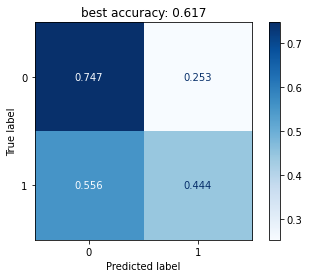

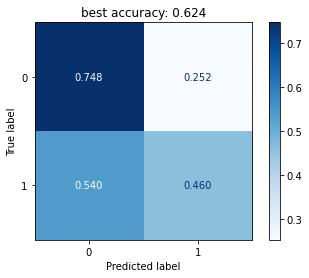

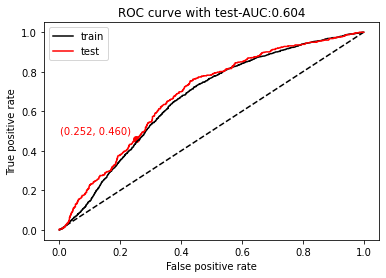

CPU times: user 789 ms, sys: 354 ms, total: 1.14 s
Wall time: 732 ms


In [48]:
#numeric featurelist from text 
feature_list = num_cols[3:]

# go into pipe with Model: LogisticRegression
pipe = make_pipeline( LogisticRegression() ) 
%time fpr__, tpr__, auc__ = my_fit_cm(df_nf, pipe, feature_list, "target")
pipe_name.append( 'inital test, LogReg' )
auc.append( auc__ )
fpr.append( fpr__ )
tpr.append( tpr__ )

## jedi playground

In [49]:
# delete
#
#test_text = "Barbados #Bridgetown JAMAICA Â\x89Ã\x9bÃ\x92 Two cars set ablaze: SANTA CRUZ Â\x89Ã\x9bÃ\x93 Head of the St Elizabeth Police Superintende"
#test_text = 'Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding'
#test_text = "#stlouis #caraccidentlawyer Speeding Among Top Causes of Teen Accidents https://t.co/k4zoMOF319 https://t.co/S2kXVM0cBA Car Accident teeÂ\x89Ã\x9b_"
#spcy_test(test_text)


In [50]:
# delete
#test_df = disaster_tweets[40:60]
#list(test_df.text)

In [51]:
#%time df1 = my_df_spacy_locgpe(test_df.copy(), 'text')
#df1

In [52]:
#df2 = my_df_spacy_fac   (df1.copy(), 'text')
#df2

# Evaluationg Basic modeling

## Train-Test-Split

##pipline Tfidf, MultinomialNB

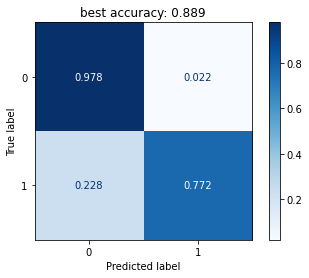

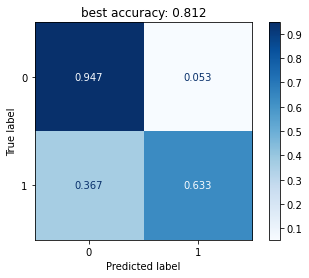

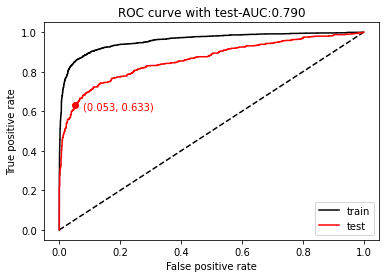

CPU times: user 1.28 s, sys: 20.2 ms, total: 1.3 s
Wall time: 1.32 s


In [53]:
################# NEW #################
df = disaster_tweets.copy() # original data set, no postprocessin
pipeMNB = make_pipeline(TfidfVectorizer(ngram_range=(1, 1)), MultinomialNB()) #### naive bayes 
%time fpr_0, tpr_0, auc_0 = my_fit_cm(df, pipeMNB, "text", "target")
pipe_name.append( 'original >> TFIDF(1,1), MNB' )
auc.append( auc_0 )
fpr.append( fpr_0 )
tpr.append( tpr_0 )

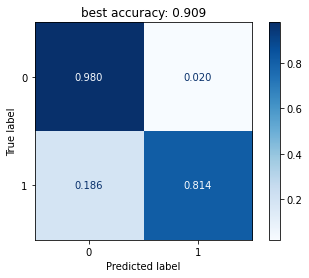

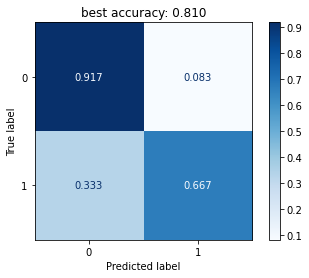

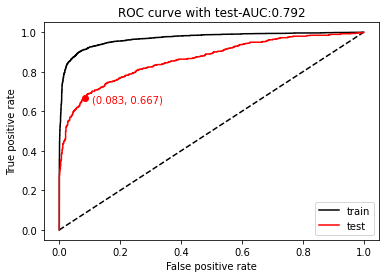

CPU times: user 963 ms, sys: 11.3 ms, total: 974 ms
Wall time: 976 ms


In [54]:
df = my_df_text_mining(disaster_tweets.copy(), 'text')  # minor postprocessing: remove numbers and #,@, .... Special characters
pipeMNB = make_pipeline(TfidfVectorizer(ngram_range=(1, 1)), MultinomialNB()) #### naive bayes 
%time fpr_1, tpr_1, auc_1 = my_fit_cm(df, pipeMNB, "text", "target")
pipe_name.append( 'clean lemma >> TFIDF(1,1), MNB' )
auc.append( auc_1 )
fpr.append( fpr_1 )
tpr.append( tpr_1 )

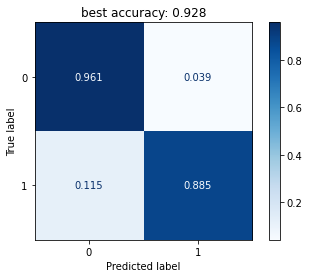

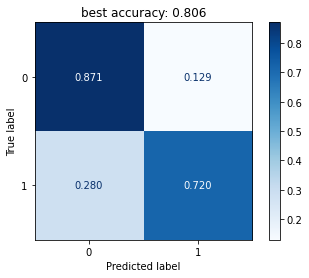

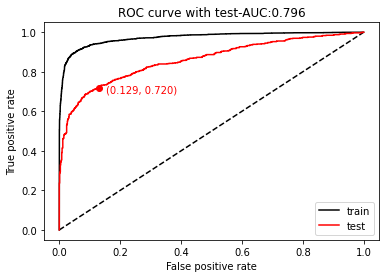

CPU times: user 946 ms, sys: 13 ms, total: 959 ms
Wall time: 961 ms


In [55]:
df = my_df_text_mining(disaster_tweets.copy(), 'text')  # minor postprocessing: remove numbers and #,@, .... Special characters
pipeMNB = make_pipeline(CountVectorizer(), MultinomialNB()) #### naive bayes 
%time fpr_2, tpr_2, auc_2 = my_fit_cm(df, pipeMNB, "text", "target")
pipe_name.append( 'clean lemma >> CV(1,1), MNB' )
auc.append( auc_2 )
fpr.append( fpr_2 )
tpr.append( tpr_2 )

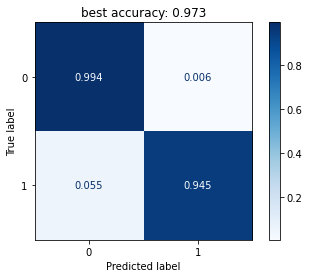

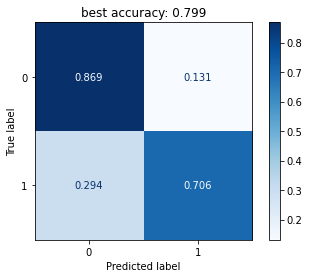

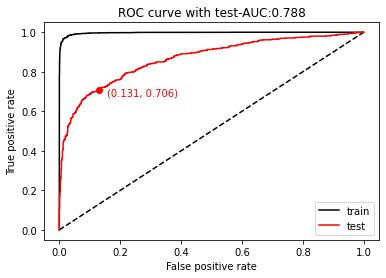

CPU times: user 1.47 s, sys: 397 ms, total: 1.87 s
Wall time: 1.4 s


In [56]:
df = my_df_text_mining(disaster_tweets.copy(), 'text')  # minor postprocessing: remove numbers and #,@, .... Special characters
pipeMNB = make_pipeline(CountVectorizer(), LogisticRegression()) 
%time fpr_3, tpr_3, auc_3 = my_fit_cm(df, pipeMNB, "text", "target")
pipe_name.append( 'clean lemma >> CV(1,1), LogReg' )
auc.append( auc_3 )
fpr.append( fpr_3 )
tpr.append( tpr_3 )

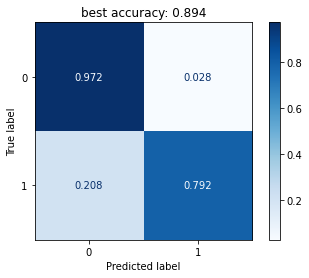

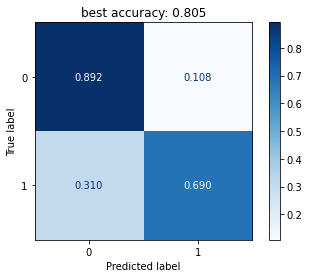

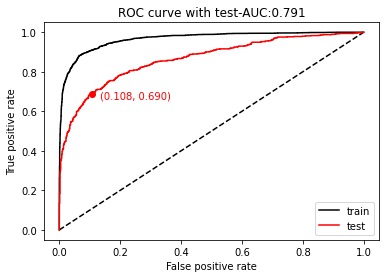

CPU times: user 1.23 s, sys: 247 ms, total: 1.47 s
Wall time: 1.2 s


In [57]:
df = my_df_text_mining(disaster_tweets.copy(), 'text')  # minor postprocessing: remove numbers and #,@, .... Special characters
pipeMNB = make_pipeline(TfidfVectorizer(ngram_range=(1, 1)), LogisticRegression()) 
%time fpr_4, tpr_4, auc_4 = my_fit_cm(df, pipeMNB, "text", "target")
pipe_name.append( 'clean lemma >> TFIDF(1,1), LogReg' )
auc.append( auc_4 )
fpr.append( fpr_4 )
tpr.append( tpr_4 )

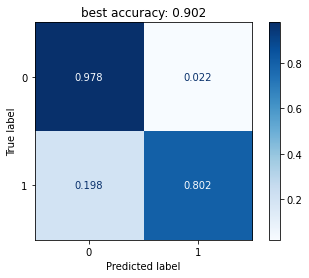

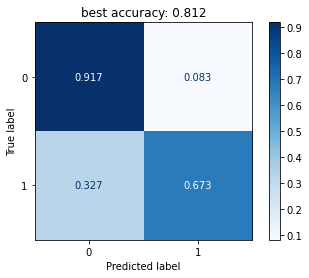

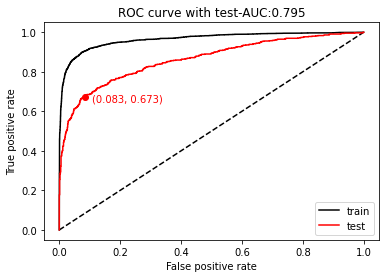

CPU times: user 958 ms, sys: 14.1 ms, total: 972 ms
Wall time: 971 ms


In [58]:
#### stemmer
df = my_df_text_mining2(disaster_tweets.copy(), 'text')  # minor postprocessing: remove numbers and #,@, .... Special characters
pipeMNB = make_pipeline(TfidfVectorizer(ngram_range=(1, 1)), MultinomialNB()) #### naive bayes 
%time fpr_5, tpr_5, auc_5 = my_fit_cm(df, pipeMNB, "text", "target")
pipe_name.append( 'cleaned, stemmer >> TFIDF(1,1), MNB' )
auc.append( auc_5 )
fpr.append( fpr_5 )
tpr.append( tpr_5 )

# Evaluation extended Modeling (weitere Spalten)

In [59]:
### AP: show result for one text line, or many example line

In [60]:
#df = my_df_spacy_locgpe(disaster_tweets.copy(), 'text')
#
#pipeMNB = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), MultinomialNB()) #### naive bayes 
#%time fpr_loc0, tpr_loc0 = my_fit_cm(df, pipeMNB, 'loc_gpe', "target")
# poor result: acc= 0.664

In [61]:
# next try
#pipe = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), LogisticRegression()) 
#%time fpr_loc1, tpr_loc1 = my_fit_cm(df, pipe, 'loc_gpe', "target")

In [62]:
# next try
#pipe = make_pipeline(CountVectorizer(), LogisticRegression()) 
#%time fpr_loc2, tpr_loc2 = my_fit_cm(df, pipe, 'loc_gpe', "target")

In [63]:
######## ERRORS ####### will keine stings :///// #######
"""
df_ = my_df_spacy_locgpe(disaster_tweets.copy(), 'text')
df  = my_df_spacy_date_time(df_ , 'text')
feature_list = ['loc_gpe','date_time']
target = "target"

# next try
pipe = make_pipeline( LogisticRegression() ) 
%time my_fit_cm(df, pipe, feature_list, "target")
"""

'\ndf_ = my_df_spacy_locgpe(disaster_tweets.copy(), \'text\')\ndf  = my_df_spacy_date_time(df_ , \'text\')\nfeature_list = [\'loc_gpe\',\'date_time\']\ntarget = "target"\n\n# next try\npipe = make_pipeline( LogisticRegression() ) \n%time my_fit_cm(df, pipe, feature_list, "target")\n'

In [64]:
# some counts
# ready to delete
df = disaster_tweets.copy()
df['_#_'] = df['text'].apply(lambda x: str(x).count('#') )
df['_@_'] = df['text'].apply(lambda x: str(x).count('@') )
df['_/_'] = df['text'].apply(lambda x: str(x).count('/') )
#df

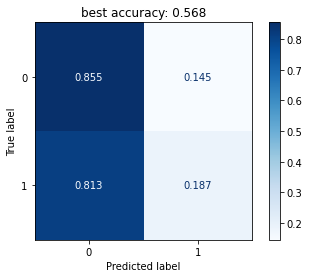

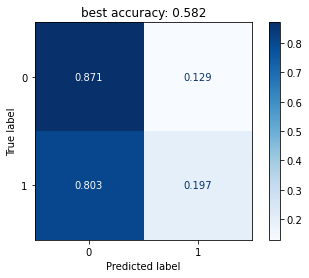

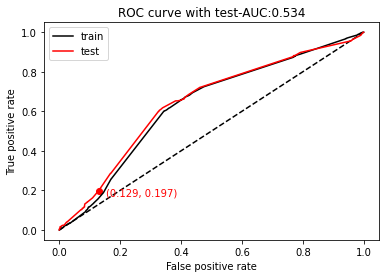

CPU times: user 696 ms, sys: 264 ms, total: 960 ms
Wall time: 653 ms


In [65]:
feature_list = ['_#_','_@_','_/_']
# next try
pipe = make_pipeline( LogisticRegression() ) 
%time fpr__ , tpr__ , auc__ = my_fit_cm(df, pipe, feature_list, "target")
pipe_name.append( 'stupid test :)' )
auc.append( auc__ )
fpr.append( fpr__ )
tpr.append( tpr__ )

# Final Model

In [66]:
# Performance

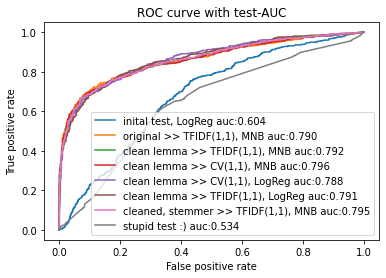

In [67]:
plot_roc_auc(pipe_name, fpr, tpr, auc)